# Import Package

In [1]:
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle

2022-06-09 21:03:50.599599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 21:03:50.599632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(f'''
{np.__version__},
{pd.__version__},
{tf.__version__}''')


1.22.4,
1.4.2,
2.9.1


In [3]:
!python --version

Python 3.8.10


# Import Dataset

In [4]:
rating = pd.read_csv('../../data/rating.csv')
kuliner = pd.read_csv('../../data/kuliner.csv')
user = pd.read_csv('../../data/user.csv')

In [5]:
# melihat ukuran data
print(f'rating : {rating.shape}')
print(f'kuliner : {kuliner.shape}')
print(f'user : {user.shape}')

rating : (10000, 3)
kuliner : (81, 12)
user : (300, 3)


# Persiapan Dataset

In [7]:
# Merubah data agar hanya dari Kota Yogyakarta

kuliner = kuliner[kuliner['City']=='Yogyakarta']
kuliner.head()


,Place_Id,Kuliner_Name,Description,Category,alamat,City,Rating,Coordinate,Lat,Long,Price,Images
0,1,Kuliner Gudeg Pecel Pasar Beringharjo Bu Yamtini,Sarapan murah dan enak di jogja yang ada di da...,Makanan,"Jl. Margo Mulyo Jl. Jend. Ahmad Yani, Ngupasan...",Yogyakarta,4.2,"{'lat': -7.79871615565743, 'lng': 110.36495915...",-7.798.716.156,1.103.649.592,8000,https://i.ytimg.com/vi/s4uaKa0e_7o/mqdefault.jpg
1,2,Soto Sampah,Ada cerita tersendiri mengenai nama Soto Sampa...,Makanan,"Jl. Kranggan No.2, Cokrodiningratan, Kec. Jeti...",Yogyakarta,4.3,"{'lat': -7.78162635992033, 'lng': 110.36692378...",-778.162.636,1.103.669.238,6000,https://cdn.krjogja.com/wp-content/uploads/201...
2,3,Kuliner Lesehan Malioboro,Lesehan yang satu ini sih cocok buat para pemb...,Makanan,"Jl. Malioboro No.143, Sosromenduran, Gedong Te...",Yogyakarta,4.3,"{'lat': -7.79180460164656, 'lng': 110.36583623...",-7.791.804.602,1.103.658.362,20000,https://img.qraved.co/v2/image/data/main-photo...
3,4,Kuliner jogja Pendopo Sop,Pendopo Sop merupakan salah satu tempat wisata...,Makanan,"Ngupasan, Kec. Gondomanan, Kota Yogyakarta, Da...",Yogyakarta,4.5,"{'lat': -7.80320108368307, 'lng':110.363208002...",-7.803.201.084,110.363.208,30000,https://ik.imagekit.io/tvlk/cul-asset/guys1L+Y...
4,6,Pusat Kuliner Leyeh Leyeh,"Leyeh Leyeh menawarkan hidangan yang beragam, ...",Makanan,"Jl. P. Mangkubumi No.10, Cokrodiningratan, Kec...",Yogyakarta,4.5,"{'lat': -7.78213066768978, 'lng': 110.36730232...",-7.782.130.668,1.103.673.023,50000,https://t-2.tstatic.net/jogja/foto/bank/images...


In [8]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [9]:
df = rating.copy()

In [10]:
#ENCODING
def dict_encoder(col, data=df):
  unique_val = data[col].unique().tolist()
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [11]:
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [12]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [13]:
# Mendapatkan jumlah user dan hotel
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
# mengubah nilai rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

In [14]:
print(f'Jumlah user : {num_users}')
print(f'Jumlah kuliner : {num_place}')
print(f'Rating minimum : {min_rating}')
print(f'Rating maximum : {max_rating}')

Jumlah user : 300
Jumlah kuliner : 437
Rating minimum : 1.0
Rating maximum : 5.0


In [15]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,207,3.0,187,262
4684,142,268,2.0,141,83
1731,54,103,3.0,53,10
4742,144,119,3.0,143,141
4521,138,288,5.0,137,283


# Splitting Dataset

In [16]:
# Mambuat Variable x
x = df[['user', 'place']].values
# membuat Variable y
y = df['Place_Ratings'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values

# split dataset
indices = int(0.8*df.shape[0])
x_train, x_test, y_train, y_test = (x[:indices],
                                    x[indices:],
                                    y[:indices],
                                    y[indices:]
                                    )
print(f'x_train : {x_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

x_train : (8000, 2)
x_test : (2000, 2)
y_train : (8000,)
y_test : (2000,)


In [17]:
class Recommended(keras.Model):
  def __init__(self,num_users, num_places, embedding_size, **kwargs):
    super(Recommended, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(num_users,
                                           embedding_size,
                                           embeddings_initializer = 'he_normal',
                                           embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users,1)
    self.places_embedding = layers.Embedding(num_places,
                                             embedding_size,
                                             embeddings_initializer='he_normal',
                                             embeddings_regularizer= keras.regularizers.l2(1e-6)
                                             )
    self.places_bias = layers.Embedding(num_places,1)

  def call(self, inputs):
    user_vec = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    places_vec = self.places_embedding(inputs[:,1])
    places_bias = self.places_bias(inputs[:,1])

    dot_user_places = tf.tensordot(user_vec, places_vec, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x)


In [18]:
model = Recommended(num_users, num_place, 50)

model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer= keras.optimizers.Adam(learning_rate=0.0004),
              metrics=[keras.metrics.RootMeanSquaredError()]
              )

2022-06-09 21:04:18.610909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 21:04:18.610954: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 21:04:18.610988: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wan): /proc/driver/nvidia/version does not exist


# training Model

In [19]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_test, y_test)
)

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 0.7005 - root_mean_squared_error: 0.3505 - val_loss: 0.7005 - val_root_mean_squared_error: 0.3502
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6976 - root_mean_squared_error: 0.3485 - val_loss: 0.6998 - val_root_mean_squared_error: 0.3497
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6983 - root_mean_squared_error: 0.3489 - val_loss: 0.6995 - val_root_mean_squared_error: 0.3495
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6929 - root_mean_squared_error: 0.3451 - val_loss: 0.6997 - val_root_mean_squared_error: 0.3496
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6927 - root_mean_squared_error: 0.3450 - val_loss: 0.6998 - val_root_mean_squared_error: 0.3497
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6925 - root_mean_squared_error: 0.3448 - val_loss: 0.6993 

250/250 [==============================] - 1s 3ms/step - loss: 0.6692 - root_mean_squared_error: 0.3279 - val_loss: 0.7015 - val_root_mean_squared_error: 0.3506
Epoch 49/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6674 - root_mean_squared_error: 0.3266 - val_loss: 0.7015 - val_root_mean_squared_error: 0.3506
Epoch 50/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6681 - root_mean_squared_error: 0.3270 - val_loss: 0.7013 - val_root_mean_squared_error: 0.3505
Epoch 51/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6676 - root_mean_squared_error: 0.3268 - val_loss: 0.7016 - val_root_mean_squared_error: 0.3507
Epoch 52/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6680 - root_mean_squared_error: 0.3271 - val_loss: 0.7012 - val_root_mean_squared_error: 0.3504
Epoch 53/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6677 - root_mean_squared_error: 0.3268 - val_loss: 0.7015 - val_r

250/250 [==============================] - 1s 3ms/step - loss: 0.6650 - root_mean_squared_error: 0.3249 - val_loss: 0.7083 - val_root_mean_squared_error: 0.3549
Epoch 96/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6637 - root_mean_squared_error: 0.3239 - val_loss: 0.7083 - val_root_mean_squared_error: 0.3549
Epoch 97/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6625 - root_mean_squared_error: 0.3231 - val_loss: 0.7080 - val_root_mean_squared_error: 0.3547
Epoch 98/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6636 - root_mean_squared_error: 0.3239 - val_loss: 0.7083 - val_root_mean_squared_error: 0.3549
Epoch 99/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6626 - root_mean_squared_error: 0.3231 - val_loss: 0.7086 - val_root_mean_squared_error: 0.3551
Epoch 100/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6634 - root_mean_squared_error: 0.3237 - val_loss: 0.7092 - val_

# Evaluasi Model

In [20]:
model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.7092 - root_mean_squared_error: 0.3555


[0.7091940641403198, 0.35546624660491943]

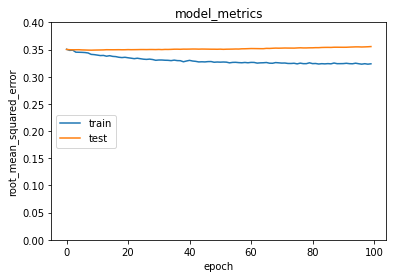

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Penerapan Model

In [22]:
kuliner.columns

Index(['Place_Id', 'Kuliner_Name', 'Description', 'Category', 'alamat', 'City',
       'Rating', 'Coordinate', 'Lat', 'Long', 'Price', 'Images'],
      dtype='object')

In [23]:
place_df = kuliner[['Place_Id', 'Kuliner_Name', 'Description', 'Category', 'alamat', 'City',
       'Rating', 'Coordinate', 'Lat', 'Long', 'Price', 'Images']]
place_df.columns = ['Place_Id', 'Kuliner_Name', 'Description', 'Category', 'alamat', 'City',
       'Rating', 'Coordinate', 'Lat', 'Long', 'Price', 'Images']
df = rating.copy()

In [24]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [25]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['Place_Id'].isin(place_visited_by_user.Place_Id.values)]['Place_Id'] 
place_not_visited = list(
    set(place_not_visited).intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [26]:
# Mengambil top 5 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 

print('')
print('----' * 15)
print('Top 5 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['Place_Id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.Kuliner_Name, '\n    ', row.alamat, ',', 'titik koordinat ', row.Coordinate, ',', 'Rating Wisata ', row.Rating,'\n')

print('==='*15)

1/1 [==============================] - 0s 169ms/step

------------------------------------------------------------
Top 5 place recommendation
------------------------------------------------------------
1 . Kuliner Gudeg Pecel Pasar Beringharjo Bu Yamtini 
     Jl. Margo Mulyo Jl. Jend. Ahmad Yani, Ngupasan, Kec. Gondomanan, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55122 , titik koordinat  {'lat': -7.79871615565743, 'lng': 110.364959159926} , Rating Wisata  4.2 

2 . Bakmi Mbah Gito 
     Jl. Nyi Ageng Nis No.9, Rejowinangun, Kec. Kotagede, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55171 , titik koordinat  {'lat': -7.81335650545829, 'lng': 110.397154007848} , Rating Wisata  4.3 

3 . Lesehan Gudeg & Oseng-oseng "bu Endang" 
     Jl. Laksda Adisucipto No.264, Ambarukmo, Caturtunggal, Kec. Depok, Kabupaten Sleman, Daerah Istimewa Yogyakarta 55281 , titik koordinat  {'lat': -7.78308779704268, 'lng': 110.399850310542} , Rating Wisata  4.1 

4 . Mie Ayam Bu Tumini Sari Rasa Jati Ayu 
 

# Save Model

In [42]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpiqpaze92/assets


In [56]:
filename = '../../model/kuliner_bali.pkl'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://7a5f6002-395b-4df0-84d3-2276807e66aa/assets


INFO:tensorflow:Assets written to: ram://7a5f6002-395b-4df0-84d3-2276807e66aa/assets


In [57]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.7042 - root_mean_squared_error: 0.3523
